In [2]:
import os
import sys

if os.name == 'nt':
    raise Exception("Windows run is not supported, see README.md. ")

RUN_PLATFORM = os.getenv("RUN_PLATFORM") or "LOCAL"
if 'google.colab' in sys.modules:
    RUN_PLATFORM = "COLAB"

if RUN_PLATFORM == "COLAB":
	print("Notebook is running on Google Colab.\n")

	from google.colab import drive
	drive.mount('/content/drive')
	!cp '/content/drive/My Drive/Birdo_data/data_updated.zip' '/content/data_updated.zip'
	!unzip '/content/data_updated.zip' -d '/content/data/'

	!curl -L -O https://raw.githubusercontent.com/asztrikx/bme-classification-bird_sounds/refs/heads/master/requirements.txt
	!pip install pytorch-lightning wandb librosa opencv-python pydub dotenv gradio -q
	data_dir = "data"
	os.makedirs(data_dir, exist_ok=True)
	#if not os.path.exists("data/train_spectrogram"):
		#!gdown 1Kqg7NQ2uAFLa6x1QuP87TXFqx4lR16Gi
		#!tar xzfv train_spectrogram.tar.gz -C data/ --checkpoint=.100
		#!gdown 1FdPskLKv7u9QNMUcU77uhfd3XhIdD3bS -O data/train_spectrogram.csv
	!curl -L https://raw.githubusercontent.com/asztrikx/bme-classification-bird_sounds/refs/heads/master/.env.template -o .env
	!curl -L https://raw.githubusercontent.com/asztrikx/bme-classification-bird_sounds/refs/heads/master/data/train_metadata_updated.csv -o data/train_metadata_updated.csv
elif RUN_PLATFORM == "LOCAL":
	print("Notebook is running locally.\n")
	# Make sure that when not in docker, packages are installed
	!pip install -r requirements.txt
	data_dir = "data"
elif RUN_PLATFORM == "KAGGLE":
	print("Notebook is running on Kaggle.\n")
	data_dir = ""

# Install ffmpeg for AudioSegment if not already (avoid sudo prompt)
!dpkg-query -W -f='${Status}\n' ffmpeg 2>/dev/null | grep -q "install ok installed" || sudo apt install -y ffmpeg

metadata_path = os.path.join(data_dir, "train_metadata_updated.csv")
audio_dir = os.path.join(data_dir, "train_audio")
spectrogram_dir = os.path.join(data_dir, "train_spectrogram")
os.makedirs(spectrogram_dir, exist_ok=True)
spectrogram_metadata_path = os.path.join(data_dir, "train_spectrogram.csv")

Notebook is running on Google Colab.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   732  100   732    0     0   1440      0 --:--:-- --:--:-- --:--:--  1438
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
	# avoid rare bugs when image won't plot
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# loads .env file into runtime env vars
import os.path
if "google.colab" in sys.modules:
	print(
		"You are in Colab so may not see hidden files (starting with '.'). "
		"To see them click on the eye icon in the header part of the Colab "
		"file explorer (where you can browse your files)."
	)
if not os.path.isfile(".env"):
	raise Exception(".env must be created by copying .env.template and filling out the values")
from dotenv import load_dotenv
load_dotenv(override=True)

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
import torchmetrics

# make it not fail in terminal execution
from IPython.display import display
from IPython.display import Audio
import gradio as gr

from types import SimpleNamespace
	# make dict to class
import pathlib
import platform

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from typing import Counter

# Audio process
import librosa
import librosa.display
import cv2
import PIL

# Threading
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

# Wandb
import wandb
wandb.login()
PROJECT_NAME = "bme-classification-bird_sounds"

You are in Colab so may not see hidden files (starting with '.'). To see them click on the eye icon in the header part of the Colab file explorer (where you can browse your files).


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: horvath-szilard (horvath-szilard-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Hyperparameter configuration, set random states

In [21]:
# hyperparameters
test_val_size = 0.2 # size of test and validation together to the whole dataset
test_size = 0.5 # size of test to test and validation together
# number of workers for data loading
if RUN_PLATFORM == "COLAB":
    num_workers = 4
elif RUN_PLATFORM == "LOCAL":
    num_workers = 4

is_gradio_on = True

# Faster exec. on newer GPUs
#torch.set_float32_matmul_precision('medium')

# Fix random early on
random_state = 42 # random state
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Metadata csv

In [22]:
metadata = pd.read_csv(metadata_path)
metadata = metadata[metadata["delete"] == False].reset_index(drop=True)

## Train test split

In [23]:
# Bugfix, remove datas based on train-test split after segmentation
df = pd.read_csv(spectrogram_metadata_path)
if not 'train_test_val' in metadata.columns and 'train_test_val' in df.columns:
	models = ["cnn", "finetune"]
	for model in models:
		modelPath = f"models/{model}.ckpt"
		if os.path.exists(modelPath):
			os.remove(modelPath)
	recreateSpectrogramTrainTestVal = True
else:
	recreateSpectrogramTrainTestVal = False

This must be done before creating segments, to avoid one audio's segments being in train set and test test also

In [24]:
if not 'train_test_val' in metadata.columns:
	train, test_val = train_test_split(metadata, test_size=test_val_size, random_state=random_state)
	test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)

	metadata.loc[train.index, "train_test_val"] = "train"
	metadata.loc[test.index, "train_test_val"] = "test"
	metadata.loc[val.index, "train_test_val"] = "val"

	metadata.to_csv(metadata_path, index=False)

In [25]:
# Bugfix
recreateSpectrogramTrainTestVal = True
if recreateSpectrogramTrainTestVal:
	df = pd.read_csv(spectrogram_metadata_path)
	df.drop(columns=['train_test_val'], inplace=True)
	df = df.merge(metadata[['filename', 'train_test_val']], left_on='audio_path', right_on='filename')
	df.drop(columns=['filename'], inplace=True)
	df.to_csv(spectrogram_metadata_path, index=False)

## Transform data (Cached)

In [26]:
def process_sound_file(file_path, save=True, save_dir=None, segment_length=3, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
	y, sr = librosa.load(file_path, sr=sr)

	segment_samples = sr * segment_length
	num_segments = int(np.ceil(len(y) / segment_samples))

	spectrogram_paths = []
	spectrograms = []
	for i in range(num_segments):
		start = i * segment_samples
		end = start + segment_samples
		segment = y[start:end]

		#TODO how should padding work
		if len(segment) < segment_samples:
			if num_segments == 1:
				segment = np.pad(segment, (0, segment_samples - len(segment)), mode='wrap')
			else:
				missing_length = segment_samples - len(segment)
				segment = np.concatenate((segment, y[:missing_length]))
		mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
		mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

		mel_spec_resized = cv2.resize(mel_spec_db, (128, 128)) # TODO n_mels?

		if save:
				image_filename = f"{os.path.basename(file_path).replace('.ogg', '')}_seg{i}.png"
				image_path = os.path.join(save_dir, image_filename)
				plt.imsave(image_path, mel_spec_resized, cmap='inferno')

				spectrogram_paths.append(image_path)
		else:
				spectrograms.append(mel_spec_resized)

	return spectrogram_paths, spectrograms

In [27]:
if not os.path.isfile(spectrogram_metadata_path):
	data = []

	# Create subdirs outside of loop
	for species in metadata["primary_label"].unique():
		os.makedirs(os.path.join(spectrogram_dir, species), exist_ok=True)

	with tqdm(total=len(metadata)) as pbar:
		with ThreadPoolExecutor() as executor:
			def get_spectrogram(filename):
				audio_path = os.path.join(audio_dir, filename)
				species = filename.split('/')[0]

				out_path = os.path.join(spectrogram_dir, species)
				audio_spectrograms, _ = process_sound_file(audio_path, save_dir=out_path, sr=32000)

				return audio_spectrograms

			futures = {
				executor.submit(get_spectrogram, filename): filename
				for filename in metadata["filename"]
			}
			for future in concurrent.futures.as_completed(futures):
				filename = futures[future]
				audio_spectrograms = future.result()

				# Get other data from metadata: do not do this in Dataset for caching
				row = metadata[metadata["filename"] == filename]
				latitude = row["latitude"].values[0]
				longitude = row["longitude"].values[0]
				author = row["author"].values[0]
				train_test_val = row["train_test_val"].values[0]

				label = species

				for audio_spectrogram in audio_spectrograms:
					audio_spectrogram = os.path.relpath(audio_spectrogram, spectrogram_dir)
					data.append((filename, audio_spectrogram, label, author, latitude, longitude, train_test_val))
				pbar.update(1)

	spectrogram_df = pd.DataFrame(data, columns=["audio_path", "spectrogram_path", "label", "author", "latitude", "longitude", "train_test_val"])
	spectrogram_df.to_csv(spectrogram_metadata_path, index=False)
else:
	spectrogram_df = pd.read_csv(spectrogram_metadata_path)

In [28]:
# Bugfix: all labels were the last labels
if (spectrogram_df["label"] == "zitcis1").all():
	spectrogram_df["label"] = spectrogram_df["audio_path"].apply(lambda path: path.split('/')[0])
	spectrogram_df.to_csv(spectrogram_metadata_path, index=False)

In [29]:
# Bugfix: Wrong slash type in path
spectrogram_df["spectrogram_path"] = spectrogram_df["spectrogram_path"].apply(lambda path: path.replace('\\', '/'))
spectrogram_df.to_csv(spectrogram_metadata_path, index=False)

## Visualize 1 audio file's spectrograms

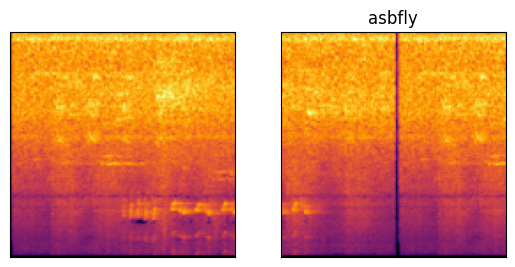

In [30]:
first_spectrograms = spectrogram_df[spectrogram_df["audio_path"] == spectrogram_df.iloc[0]["audio_path"]]
first_spectrograms_paths = first_spectrograms["spectrogram_path"].sort_values(ascending=True)

fig, ax = plt.subplots(1, len(first_spectrograms_paths))
for i, first_spectrograms_path in enumerate(first_spectrograms_paths):
	fullpath = os.path.join(spectrogram_dir, first_spectrograms_path)

	ax[i].imshow(mpimg.imread(fullpath))
	ax[i].set_xticks([])
	ax[i].set_yticks([])

plt.title(spectrogram_df.iloc[0]["label"]);

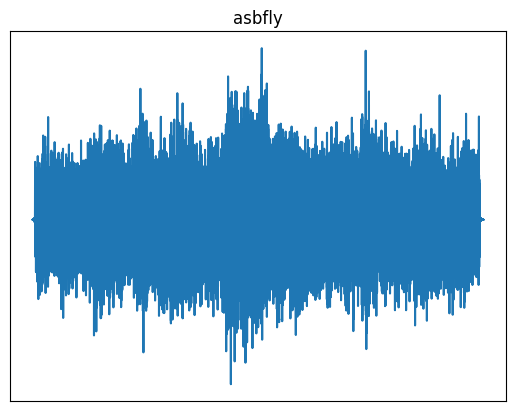

In [31]:
from pydub import AudioSegment

audio = AudioSegment.from_ogg(os.path.join(audio_dir, spectrogram_df.iloc[0]["audio_path"]))
samples = np.array(audio.get_array_of_samples())
if audio.channels == 2:
    samples = samples.reshape((-1, 2))
time_axis = np.linspace(0, len(audio) / 1000, num=len(samples))
plt.xticks([])
plt.yticks([])
plt.title(spectrogram_df.iloc[0]["label"]);
plt.plot(time_axis, samples)

## Custom Dataset

In [32]:
# Convert string labels to integer label IDs with LabelEncoder
label_encoder = LabelEncoder()
df = pd.read_csv(spectrogram_metadata_path)
df["label_id"] = label_encoder.fit_transform(df["label"])
df.to_csv(spectrogram_metadata_path, index=False)

In [33]:
class BirdsDataset(Dataset):
	# override
	def __init__(self, csv, train_test_val, transform = None, target_transform = None):
		self.df = pd.read_csv(csv)
		self.df = self.df[self.df["train_test_val"] == train_test_val].reset_index(drop=True)
		self.transform = transform
		self.target_transform = target_transform

	# override
	def __len__(self):
		return len(self.df)

	# override
	def __getitem__(self, index):
		image_path = self.df.iloc[index]["spectrogram_path"]
		if not image_path.startswith("data/train_spectrogram/"):
			image_path = "data/train_spectrogram/" + image_path
		audio = PIL.Image.open(image_path).convert('RGB')
		audio = transforms.functional.to_tensor(audio)

		label = {
			"label": self.df.iloc[index]["label"],
			"label_id": self.df.iloc[index]["label_id"],
			"latitude": self.df.iloc[index]["latitude"],
			"longitude": self.df.iloc[index]["longitude"],
			"author": self.df.iloc[index]["author"],
		}

		if self.transform:
			audio = self.transform(audio).to(torch.float32)
		if self.target_transform:
			label = self.target_transform(label)
		return audio, label

## Data module

In [34]:
class BirdsDataModule(pl.LightningDataModule):
	def __init__(self, spectrogram_metadata_path, batch_size, base_transform):
		super().__init__()
		self.batch_size = batch_size
		self.base_transform = transforms.Compose([
			base_transform
		])

		self.train_dataset = BirdsDataset(spectrogram_metadata_path, "train", transform = self.base_transform)
		self.val_dataset = BirdsDataset(spectrogram_metadata_path, "val", transform = self.base_transform)
		self.test_dataset = BirdsDataset(spectrogram_metadata_path, "test", transform = self.base_transform)

	# override
	def train_dataloader(self):
		return DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			# Windows: Sanity check hanged, when disabled epoch bar never showed, it just loaded infinitely: https://stackoverflow.com/a/70949425/4404911
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=True,
			persistent_workers=True
				# avoid recreating after every fast epoch
		)

	# override
	def val_dataloader(self):
		return DataLoader(
			self.val_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=False,
			shuffle=False,
			persistent_workers=True
		)

	# override
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=False,
			shuffle=False,
			persistent_workers=True
		)

## Baseline

Random

In [ ]:
labels = df["label"].unique()
print(f"Label count: {len(labels)}")
print(f"Chance for random to predict per audio: {1/len(labels) * 100:.2f}%")

tests = df[df["train_test_val"] == "test"]

Label count: 182
Chance for random to predict per audio: 0.55%


In [ ]:
baseline_random_real = tests["label"]
baseline_random_predicted = np.random.choice(labels, len(tests))

expected_correct = len(tests) * 1 / len(labels)
actual_correct = (baseline_random_real == baseline_random_predicted).sum()

print(f"Expected multiclass accuracy: {expected_correct / len(tests) * 100:.2f}%")
print(f"Got: {actual_correct / len(tests) * 100:.2f}%")

Expected multiclass accuracy: 0.55%
Got: 0.42%


In [ ]:
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(labels))

baseline_random_real = tests["label_id"]
baseline_random_real = torch.from_numpy(baseline_random_real.to_numpy())
baseline_random_predicted = np.random.choice(df["label_id"].unique(), len(tests))
baseline_random_predicted = torch.from_numpy(baseline_random_predicted)

print(f"Same with torchmetrics: {accuracy(baseline_random_predicted, baseline_random_real).item() * 100:.2f}%")

Same with torchmetrics: 0.55%


CNN

In [ ]:
batch_size = 256

In [ ]:
# https://pytorch-lightning.readthedocs.io/en/0.10.0/lightning_module.html
class CNN(pl.LightningModule):
	def __init__(self, labels_count, learning_rate, weight_decay):
		super().__init__()

		# Log hyperparameters
		self.save_hyperparameters()
		self.learning_rate = learning_rate
		self.weight_decay = weight_decay

		self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=labels_count)

		self.model = torch.nn.Sequential(
			torch.nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
			torch.nn.BatchNorm2d(64),
			torch.nn.ReLU(),
			torch.nn.Dropout(0.3),

			torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
			torch.nn.BatchNorm2d(128),
			torch.nn.ReLU(),
			torch.nn.Dropout(0.3),

			torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
			torch.nn.BatchNorm2d(256),
			torch.nn.ReLU(),
			torch.nn.Dropout(0.3),

			torch.nn.AdaptiveAvgPool2d((4, 4)),
			torch.nn.Flatten(),

			torch.nn.Linear(4096, 256),
			torch.nn.BatchNorm1d(256),
			torch.nn.ReLU(),
			torch.nn.Dropout(0.5),

			torch.nn.Linear(256, labels_count)
		)

	# override
	def forward(self, x):
		return self.model(x)

	# https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.LightningModule.html#lightning.pytorch.core.LightningModule.log
	def common_step(self, batch, batch_idx, train_val_test, prog_bar=False, on_epoch=None):
		pred_labels = self(batch[0])

		loss = F.cross_entropy(pred_labels, batch[1]["label_id"],label_smoothing=0.1)
		accuracy = self.accuracy(pred_labels, batch[1]["label_id"])

		self.log(f"{train_val_test}_loss", loss, on_epoch=on_epoch, prog_bar=prog_bar)
		self.log(f"{train_val_test}_acc", accuracy, on_epoch=on_epoch, prog_bar=prog_bar)
		return loss

	def training_step(self, batch, batch_idx):
		return self.common_step(batch, batch_idx, "train", on_epoch=True, prog_bar =True)

	def validation_step(self, batch, batch_idx):
		return self.common_step(batch, batch_idx, "val", prog_bar=True)

	def test_step(self, batch, batch_idx):
		return self.common_step(batch, batch_idx, "test")

	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

def train_cnn(config=None):
	model_name = "cnn"
	if config is None:
		config = {
			"optimizer_name": "adamw",
			"learning_rate": 0.001,
			"weight_decay": 1e-3,
			"epoch": 200,
			"early_stop_patience": 10,
		}

	with wandb.init(config=config, project=PROJECT_NAME):
		config = wandb.config
		wandb_logger = WandbLogger(log_model=True)
		wandb_logger.log_hyperparams(config)
		print(f"\nConfig to be used: {config}\n")

		dm = BirdsDataModule(spectrogram_metadata_path, batch_size, torch.nn.Identity())

		model = CNN(len(labels), config.learning_rate, config.weight_decay)

		trainer = pl.Trainer(
			max_epochs=config.epoch,
			callbacks=[
				pl.callbacks.ModelCheckpoint(
					monitor="val_acc",
					save_top_k=1,
					mode="max",
					dirpath=f'./models/',
					filename=model_name
				),
				pl.callbacks.EarlyStopping(
					monitor="val_acc",
					patience=config.early_stop_patience,
					verbose=False,
					mode="max"
				)
			],
			logger = wandb_logger,
			log_every_n_steps=50,
			accelerator=device,
			devices=1,
			#precision="16-mixed",
			#fast_dev_run = True,
		)
		trainer.fit(model, dm)
		trainer.test(dataloaders=dm.test_dataloader())
		return model

In [22]:
def get_cnn(config=None):
	model_name = "cnn4"
	if os.path.isfile(f"models/{model_name}.ckpt"):
		model = CNN.load_from_checkpoint(f"models/{model_name}.ckpt", batch_size=batch_size)
		model = train_cnn(config)
			# https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#load-from-checkpoint
	else:
		model = train_cnn(config)

	model.eval()
	return model

wandb.finish()
cnn = get_cnn()

/home/asztrikx/bird-train/.venv/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.



Config to be used: {'optimizer_name': 'adamw', 'learning_rate': 0.001, 'weight_decay': 0.001, 'epoch': 200, 'early_stop_patience': 10}



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/asztrikx/bird-train/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/asztrikx/bird-train/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | Sequential         | 1.8 M  | train
--------------------------------------------------------
1.8 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/asztrikx/bird-train/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/asztrikx/bird-train/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 250. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/asztrikx/bird-train/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/asztrikx/bird-train/models/cnn-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/asztrikx/bird-train/models/cnn-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

/home/asztrikx/bird-train/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4321075975894928     │
│         test_loss         │     3.130643367767334     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
test_acc,▁
test_loss,▁
train_acc_epoch,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
train_acc_step,▁▃▄▃▄▆▆▆▇▆▆▆▇▇▇▆▇▇▇▇▇█▇▇▆█▇▇▇▇▇▇▇█▇▇▇▇█▇
train_loss_epoch,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▄▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▃▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇████▇▇█████▇
val_loss,█▅▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▂▁▂
epoch,37


## Model

In [41]:
val_size = 0.1
test_size = 0.2
epochs = 20
# batch_size = 1024+128*3  # TODO: Why was the batch size this huge? 16-32-64, maximum 500 was the largest I saw so far, ever
batch_size = 64

num_classes = pd.read_csv("data/train_metadata_updated.csv")["primary_label"].nunique()

### Define model

In [42]:
class BirdSoundsNet(pl.LightningModule):
    def __init__(self, base_model, head_model, num_classes, learning_rate=1e-3, weight_decay=1e-4, warmup_epochs=3):
        super().__init__()
        self.base_model = base_model
        self.head_model = head_model
        self.model = nn.Sequential(self.base_model, self.head_model)

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.warmup_epochs = warmup_epochs
        self.base_model_frozen = True

        # Freeze base model initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def common_step(self, batch, batch_idx, train_val_test, prog_bar=False, on_epoch=None):
        pred_labels = self(batch[0])
        loss = F.cross_entropy(pred_labels, batch[1]["label_id"])
        acc = self.accuracy(pred_labels, batch[1]["label_id"])

        self.log(f"{train_val_test}_loss", loss, on_epoch=on_epoch, prog_bar=prog_bar)
        self.log(f"{train_val_test}_acc", acc, on_epoch=on_epoch, prog_bar=prog_bar)
        return loss

    def training_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx, "train", on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx, "val", prog_bar=True)

    def test_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx, "test")

    def on_train_epoch_start(self):
        if self.current_epoch >= self.warmup_epochs and self.base_model_frozen:
            print(f"Unfreezing base model at epoch {self.current_epoch}")
            for param in self.base_model.parameters():
                param.requires_grad = True
            self.base_model_frozen = False

    def configure_optimizers(self):
        if self.base_model_frozen:
            return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        # Separate learning rates for base and head
        optimizer = torch.optim.Adam([
            {"params": self.base_model.parameters(), "lr": self.learning_rate * 0.1},
            {"params": self.head_model.parameters(), "lr": self.learning_rate},
        ], weight_decay=self.weight_decay)

        return optimizer

In [ ]:
from torchvision.models import (
    resnet50,
    ResNet50_Weights,
    mobilenet_v3_large,
    MobileNet_V3_Large_Weights,
    efficientnet_b1,
    EfficientNet_B1_Weights
)

def train_model(config=None):
    model_name = "finetune"
    if config is None:
        config = {
          "learning_rate": 1e-4,
          "weight_decay": 1e-5,
          "base_model": "efficientnet_b1",
          "freeze_base_model": False,  # not needed anymore
          "dropout": 0.3,
          "hidden_layers": 2,
          "warmup_epochs": 3
        }


    with wandb.init(config=config, project=PROJECT_NAME):
        config = wandb.config
        wandb_logger = WandbLogger(log_model=True)
        wandb_logger.log_hyperparams(config)
        print(f"\nConfig to be used: {config}\n")
        base_model_name = config["base_model"]
        # Define base model according to config
        if base_model_name == "resnet50":
            weights = ResNet50_Weights.IMAGENET1K_V1
            base_model = resnet50(weights=weights)
            preprocess = weights.transforms()

            # Get the output size before removing the head
            base_model_out_size = base_model.fc.in_features
            base_model.fc = nn.Identity()

        elif base_model_name == "mobilenet_v3_large":
            weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1
            base_model = mobilenet_v3_large(weights=weights)
            preprocess = weights.transforms()

            # Get the output size before removing the head
            base_model_out_size = base_model.classifier[-1].in_features
            base_model.classifier = nn.Identity()

        elif base_model_name == "efficientnet_b1":
            weights = EfficientNet_B1_Weights.IMAGENET1K_V1
            base_model = efficientnet_b1(weights=weights)
            preprocess = weights.transforms()

            # Get the output size before removing the head
            base_model_out_size = base_model.classifier[-1].in_features
            base_model.classifier = nn.Identity()

        else:
            raise ValueError(f"Unknown base model: {base_model_name}")

        # Load spectrogram metadata
        birds_dm = BirdsDataModule(spectrogram_metadata_path, batch_size, preprocess)

        # Define head model according to config
        #head_model = nn.Sequential()
        #base_model_out_size = base_model.fc.out_features if base_model_name == "resnet50" else base_model.classifier[-1].out_features

        # Add connect layer to head model
        #current_hidden_size = 2000
        #dropout = config["dropout"]
        #head_model.add_module(f"layer_connect", nn.Linear(base_model_out_size, current_hidden_size))
        #head_model.add_module(f"relu_connect", nn.ReLU())
        #head_model.add_module(f"dropout_connect", nn.Dropout(dropout))

        # Add hidden layers to head model
        #for layer in range(config["hidden_layers"]):
           # head_model.add_module(f"hidden_layer_{layer}", nn.Linear(current_hidden_size, current_hidden_size // 2))
          #  current_hidden_size = current_hidden_size // 2
         #   head_model.add_module(f"hidden_relu_{layer}", nn.ReLU())
        #    head_model.add_module(f"hidden_dropout_{layer}", nn.Dropout(dropout))

        # Add final layer to head model
        #head_model.add_module(f"layer_final", nn.Linear(current_hidden_size, num_classes))
        head_model = nn.Sequential(
              nn.Linear(base_model_out_size, 1024),
              nn.BatchNorm1d(1024),
              nn.ReLU(),
              nn.Dropout(0.3),
              nn.Linear(1024, num_classes)
          )


        # Instantiate model
        model = BirdSoundsNet(
            base_model=base_model,
            head_model=head_model,
            num_classes=num_classes,
            learning_rate=config["learning_rate"],
            weight_decay=config["weight_decay"],
            warmup_epochs=config.get("warmup_epochs", 3),  # Default: 3
        )

        # Register checkpointing and early stopping callbacks
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            monitor="val_acc",
            save_top_k=1,
            mode="max",
            dirpath='./models/',
            filename=f"{model_name}_{config["hidden_layers"]}_{config["dropout"]}_{config["learning_rate"]}_{config["weight_decay"]}_{config["freeze_base_model"]}_{config["base_model"]}_{config.get("warmup_epochs", 3)}",
        )
        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor="val_acc",
            patience=3,
            verbose=False,
            mode="max",
        )

        trainer = pl.Trainer(
            max_epochs=epochs,
            callbacks=[checkpoint_callback, early_stop_callback],
            logger = wandb_logger,
            # Sanity check overruns max memory
            num_sanity_val_steps=0,
            log_every_n_steps=50,
            accelerator=device,
            devices=1,
            #precision="16-mixed",
                # 32 biten tárolva, de a lényeges számítások 16 biten
        )

        # Train the model
        trainer.fit(model, datamodule=birds_dm)
        trainer.test(model, datamodule=birds_dm)

        return model

### Train without or without `Wandb` sweeps

In [26]:
def get_model(config=None):
	model_name = "finetune3"
	if os.path.isfile(f"models/{model_name}.ckpt"):
		model = BirdSoundsNet.load_from_checkpoint(f"models/{model_name}.ckpt", batch_size=batch_size)
			# https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#load-from-checkpoint
	else:
		wandb.finish()
		if True:
			model = train_model(config)
		else:
			sweep_config = {
				'method': 'random',  # TODO: should try 'bayesian' or 'grid'
				'metric': {
					'name': 'val_acc',
					'goal': 'maximize'
				},
				'parameters': {
					'hidden_layers': {
						'values': [1, 2, 3]
					},
					'dropout': {
						'values': [0.1, 0.3, 0.5]
					},
					'learning_rate': {
						'values': [1e-3, 1e-4]
					},
					'weight_decay': {
						'values': [0, 1e-4, 1e-5]
					},
					'freeze_base_model': {
						'values': [True]
					},
					'base_model': {
						'values': ['resnet50', 'mobilenet_v3_large', 'efficientnet_b1']
					}
				}
			}
			sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)
			wandb.agent(sweep_id, train_model, count=10)
		wandb.finish()

	model.eval()
	return model

model = get_model()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.



Config to be used: {'learning_rate': 0.0001, 'weight_decay': 1e-05, 'base_model': 'efficientnet_b1', 'freeze_base_model': False, 'dropout': 0.3, 'hidden_layers': 2, 'warmup_epochs': 3}



INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/models exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | base_model | EfficientNet       | 6.5 M  | train
1 | head_model | Sequential         | 1.5 M  | train
2 | model      | Sequential         | 8.0 M  | train
3 | accuracy   | MulticlassAccuracy | 0      | train
----------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing base model at epoch 3


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5810264945030212     │
│         test_loss         │     2.493861198425293     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
test_acc,▁
test_loss,▁
train_acc_epoch,▁▂▂▄▅▆▇▇███████████
train_acc_step,▁▂▂▃▅▅▆▆▆▆▆▇▇▇▇▇▇███▇▇██▇▇█▇████████████
train_loss_epoch,█▇▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▆▇▆▆▅▅▅▄▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▂▂▆▇▇█████████████
val_loss,█▇▇▂▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃
epoch,19


## Final application (`Gradio`)

In [ ]:
# Parameters
SEGMENT_LENGTH = 3

base_model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
preprocess = EfficientNet_B1_Weights.IMAGENET1K_V1.transforms()

# Instantiate dummy model (TODO: replace with fully trained one)
model = BirdSoundsNet(
    base_model=base_model,
    head_model=nn.Linear(base_model.classifier[-1].out_features, num_classes),
    num_classes=num_classes,
    learning_rate=1e-4,
    weight_decay=1e-4,
    freeze_base_model=True,
)
model = model.to(device)

### Utility functions to help with prediction and visualization

In [ ]:
def label_id_to_label(label_id):
    """Convert label id to label name."""
    if label_id is None:
        return None
    try:
        return label_encoder.inverse_transform([label_id])[0]
    except ValueError:
        return "Unknown"

def get_nth_predicted_class(predicted_classes, n):
    """Return the nth predicted class and its ratio in light of all the input audio segments."""
    if n >= len(predicted_classes):
        return {"class": None, "ratio": None}

    counter_list = Counter(predicted_classes).most_common(3)
    if n >= len(counter_list):
        return {"class": None, "ratio": None}

    predicted_class = counter_list[n][0]
    predicted_class_ratio = counter_list[n][1] / len(predicted_classes)
    return {"class": predicted_class, "ratio": predicted_class_ratio}

@torch.inference_mode()
def predict_class_from_multiple_spectrograms(spectrograms, model, preprocess):
    """Predict class from multiple spectrograms (e.g. from multiple audio segments from a single input audio)."""
    model.eval()
    predicted_classes = []

    # Iterate through spectrograms
    for spectrogram in spectrograms:
        # Preprocess spectrogram
        spectrogram = PIL.Image.fromarray(np.uint8(spectrogram)).convert('RGB')
        spectrogram = transforms.functional.to_tensor(spectrogram)
        spectrogram = preprocess(spectrogram).to(torch.float32).unsqueeze(0).to(device)

        # Make prediction
        prediction = model(spectrogram)
        predicted_class = torch.argmax(prediction, dim=1).item()
        predicted_classes.append(predicted_class)

    return predicted_classes

@torch.inference_mode()
def predict_class(audio_path):
    """Predict class from a single input audio file with the 3 most common predicted classes."""
    # Preprocess audio file and produce spectrograms with specified parameters
    _, spectrograms = process_sound_file(audio_path, save=False)

    # Run inference with the model or mock it out
    if model is not None:
        predicted_classes = predict_class_from_multiple_spectrograms(spectrograms, model, preprocess)
        prediction_1 = get_nth_predicted_class(predicted_classes, 0)
        prediction_2 = get_nth_predicted_class(predicted_classes, 1)
        prediction_3 = get_nth_predicted_class(predicted_classes, 2)
    else:
        prediction_1 = {"class": "mocked_class", "ratio": None}
        prediction_2 = {"class": "mocked_class", "ratio": None}
        prediction_3 = {"class": "mocked_class", "ratio": None}
        predicted_classes = ["mocked_class"] * len(spectrograms)

    # Normalize for Gradio (necessary, only accepts [-1, 1] images)
    normalized_spectrograms = [
        (mel_spec_resized - np.min(mel_spec_resized)) / (np.max(mel_spec_resized) - np.min(mel_spec_resized))
        for mel_spec_resized in spectrograms
    ]

    spectrograms_with_pred_labels = [
        (normalized_spectrograms[i], f"Segment: {i}, Class: '{label_id_to_label(predicted_classes[i])} ({predicted_classes[i]})'")
         for i in range(len(normalized_spectrograms))
    ]

    return (
        f"{label_id_to_label(prediction_1['class'])} ({prediction_1['class']})", prediction_1["ratio"],
        f"{label_id_to_label(prediction_2['class'])} ({prediction_2['class']})", prediction_2["ratio"],
        f"{label_id_to_label(prediction_3['class'])} ({prediction_3['class']})", prediction_3["ratio"],
        spectrograms_with_pred_labels
    )

### Launch the app

In [ ]:
def create_app(process):
    """Create Gradio bird sound classification app."""
    with gr.Blocks() as app:
        title = gr.HTML("<h1>chirp.ai 🐦</h1>")
        subtitle = gr.HTML("<h3><i>Bird Sound Classification with a Deep Neural Network</i></h3>")

        with gr.Row():
            with gr.Column(scale=2, min_width=300):
                audio_file = gr.Audio(type="filepath", label="Audio to classify")

                with gr.Accordion("Spectrogram view", open=False):
                    spectrogram_images = gr.Gallery(
                        label=f"Mel spectrograms of the audio ({SEGMENT_LENGTH} second segments)",
                        columns=5,
                        object_fit="scale-down"
                    )

            with gr.Column(scale=1, min_width=300):
                with gr.Group():
                    with gr.Column():
                        with gr.Row():
                            result = gr.Textbox(label="1st predicted class", interactive=False)
                            result_ratio = gr.Textbox(label="Ratio of all segments", interactive=False)
                        with gr.Row():
                            result_2 = gr.Textbox(label="2nd predicted class", interactive=False)
                            result_ratio_2 = gr.Textbox(label="Ratio of all segments", interactive=False)
                        with gr.Row():
                            result_3 = gr.Textbox(label="3rd predicted class", interactive=False)
                            result_ratio_3 = gr.Textbox(label="Ratio of all segments", interactive=False)

                submit_button = gr.Button("Predict")
                submit_button.click(
                    process,
                    inputs=audio_file,
                    outputs=[
                        result, result_ratio, result_2, result_ratio_2,
                        result_3, result_ratio_3, spectrogram_images
                    ]
                )

    return app

if is_gradio_on:
    app = create_app(predict_class)
    app.queue().launch(debug=True)